# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv(filepath_or_buffer='Udacity_AZDIAS_Subset.csv', delimiter=";")

# Load in the feature summary file.
feat_info = pd.read_csv(filepath_or_buffer='AZDIAS_Feature_Summary.csv', delimiter=";")

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)
azdias.head(5)

(891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
print(feat_info.shape)
feat_info.head(5)

(85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Get the count of null values for each column
#azdias.isnull().sum()

In [3]:
# Identify missing or unknown data values and convert them to NaNs.

for index, rows in feat_info.iterrows():
    feature_name = feat_info.iloc[index, 0]
    missing_or_unknown = feat_info.iloc[index, 3]
    missing_or_unknown = missing_or_unknown.replace('[', '').replace(']', '').replace(',', ' ')
    list_missing_or_unknown = list(missing_or_unknown.split(' '))
    
    azdias.loc[azdias[feature_name].isin(list_missing_or_unknown), feature_name] = np.nan    
          
    #print(f"Done processing NaNs for {feature_name}")
    #break

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

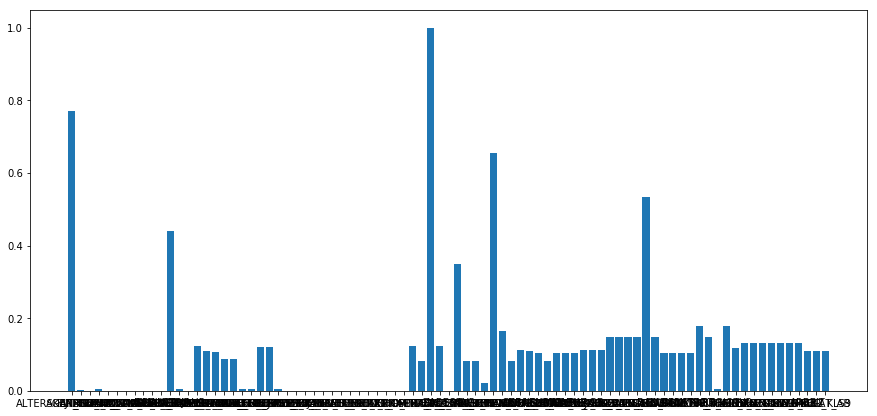

In [7]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
total_rows = azdias.shape[0]
features_nan_proportion = (azdias.isnull().sum())/total_rows

names = features_nan_proportion.index.tolist()
values = features_nan_proportion.values

plt.figure(1, figsize=(15, 7))
plt.bar(names, values)
plt.show()

In [8]:
# Investigate patterns in the amount of missing data in each column.

# Get the list of features that has 80% NaN values or higher
print(features_nan_proportion[features_nan_proportion.values > 0.2])

AGER_TYP        0.769554
GEBURTSJAHR     0.440203
TITEL_KZ        0.997576
ALTER_HH        0.348137
KK_KUNDENTYP    0.655967
KBA05_BAUMAX    0.534687
dtype: float64


In [4]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias.drop(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'], axis=1, inplace=True)

#### Discussion 1.1.2: Assess Missing Data in Each Column

**Q. Are there any patterns in missing values?**

1. When you plot the features against their count of NaN values, we can observe that most of the columns (that has NaN values) have NaN's in the range of 20% of lower.

2. The number of NaNs among some of the features was exactly the same. For example:

CAMEO_DEUG_2015           98979
CAMEO_DEU_2015            98979
CAMEO_INTL_2015           98979

This makes sense as all of these features relates to the current life stage of the individual in varying detail. There are more examples of other features with same exact number of NaNs, denoting similar features in the data set. 

**Q. Which columns were removed from the dataset?)**

We then ran a query to get the list of columns that has NaN values more than 20%, which returned the following 6 features:

'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'

These columns were dropped from the dataframe.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

(array([6.97109e+05, 7.76340e+04, 1.28010e+04, 9.53300e+03, 8.29000e+02,
        1.55000e+02, 1.40160e+04, 5.03100e+03, 2.80380e+04, 4.60750e+04]),
 array([ 0. ,  4.9,  9.8, 14.7, 19.6, 24.5, 29.4, 34.3, 39.2, 44.1, 49. ]),
 <a list of 10 Patch objects>)

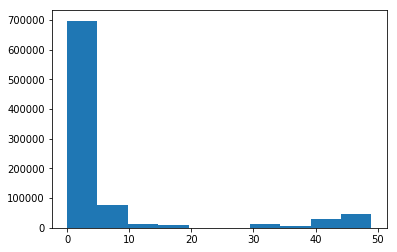

In [10]:
# How much data is missing in each row of the dataset?

rows_nan = azdias.isnull().sum(axis=1)
plt.hist(rows_nan)

In [5]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

azdias1 = azdias[azdias.isnull().sum(axis=1) <= 20]
print(azdias1.shape)
azdias2 = azdias[azdias.isnull().sum(axis=1) > 20]
print(azdias2.shape)

(797426, 79)
(93795, 79)


In [12]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Plot function that plots a single feature on two azdias samples

def plot_feature_comparison(feature_name):

    fig1 = plt.figure()
    ax1 = fig1.add_subplot(211)
    ax1.hist(azdias1[feature_name])
    ax2 = fig1.add_subplot(212)
    ax2.hist(azdias2[feature_name])
    plt.show()

C:\Users\urdee\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\urdee\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


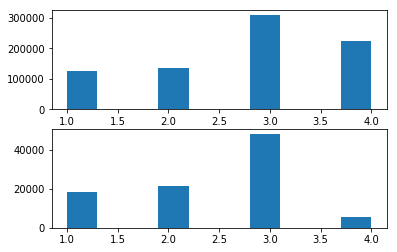

In [13]:
# Plot for feature #1 ALTERSKATEGORIE_GROB

plot_feature_comparison('ALTERSKATEGORIE_GROB')

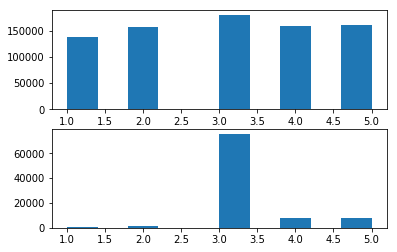

In [14]:
# Plot for feature #2 FINANZ_MINIMALIST

plot_feature_comparison('FINANZ_MINIMALIST')

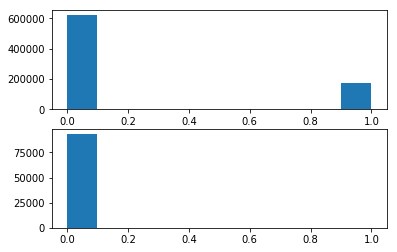

In [15]:
# Plot for feature #3 GREEN_AVANTGARDE

plot_feature_comparison('GREEN_AVANTGARDE')

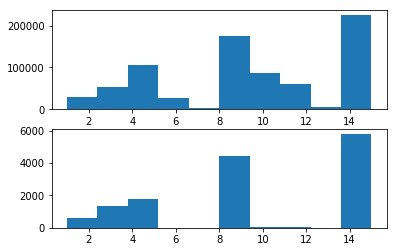

In [16]:
# Plot for feature #4 PRAEGENDE_JUGENDJAHRE

plot_feature_comparison('PRAEGENDE_JUGENDJAHRE')

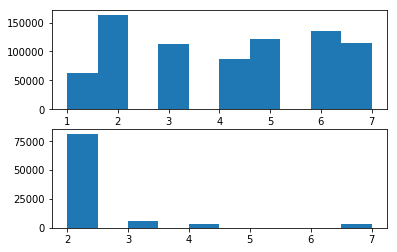

In [17]:
# Plot for feature #5 SEMIO_SOZ

plot_feature_comparison('SEMIO_SOZ')

#### Discussion 1.1.3: Assess Missing Data in Each Row

**Q. Are the data with lots of missing values are qualitatively different from data with few or no missing values?**

Yes. From the plots above, we can observe that most of the feature attributes represented are much smaller, when compared with the azdias1 sample, which has no NaN values. This was true for all features excpet for ALTERSKATEGORIE_GROB feature. Therefore, it is prudent to retain those rows.

However, it is to be noted that roughly 90% of the rows has NaN's less than 20, so it makes sense to keep only this statistically significant data to perform further operations.

In [6]:
# We are taking only rows with NaN's less than 20 for further operations
azdias = azdias1.copy()
azdias.shape

(797426, 79)

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [19]:
# How many features are there of each data type?

feat_info.groupby(['type'])['attribute'].count()

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
Name: attribute, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [20]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

feat_info[feat_info['type'] == 'categorical']

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]


In [7]:
# Re-encode categorical variable(s) to be kept in the analysis.

# replace the non numeric values in OST_WEST_KZ feature

d = {'O': 1, 'W': 2}

azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].map(d)

In [8]:
# Drop redundant columns from further analysis

azdias.drop(['GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015'], axis=1, inplace=True)
azdias.drop("GEBAEUDETYP", axis=1, inplace=True)

#### Discussion 1.2.1: Re-Encode Categorical Features

**Q. Regarding categorical features, which ones did you keep, which did you drop, and what engineering steps did you perform?**

There were 21 categorical features in the dataset.

The following features were already removed during step 1.1.2 due to the presense of large number of NaN values.

1. AGER_TYP
2. TITEL_KZ
3. KK_KUNDENTYP

The following binary values were retained without making any changes:

1. ANREDE_KZ
2. GREEN_AVANTGARDE
3. SOHO_KZ
4. VERS_TYP
5. OST_WEST_KZ

However, the feature *OST_WEST_KZ* was accepting non numeric values for East (O) and West (W). Therefore this was remapped to numeric values of (1, 2).

The following multi level columns were dropped: 

1. GFK_URLAUBERTYP
2. LP_FAMILIE_FEIN
3. LP_STATUS_FEIN
4. CAMEO_DEU_2015

This is because these features have many values, or they are reduntant as they are detailed versions of other features. For example LP_FAMILIE_FEIN is a specialization of LP_FAMILIE_GROB, both of which is used to denote 'Family Type'.

The following multi level features were retained:

1. CJT_GESAMTTYP
2. FINANZTYP
3. LP_FAMILIE_GROB
4. LP_STATUS_GROB
5. NATIONALITAET_KZ
6. SHOPPER_TYP
7. ZABEOTYP
8. GEBAEUDETYP
9. CAMEO_DEUG_2015


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [23]:
feat_info[feat_info['type'] == 'mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [9]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

azdias.insert(azdias.shape[1], "DECADE", np.nan, True)
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([1,2]), "DECADE"] = 1940
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([3,4]), "DECADE"] = 1950
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([5,6,7]), "DECADE"] = 1960
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([8,9]), "DECADE"] = 1970
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([10,11,12,13]), "DECADE"] = 1980
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([14,15]), "DECADE"] = 1990

azdias.insert(azdias.shape[1], "MOVEMENT", np.nan, True)
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([1,3,5,8,10,12,14]), "MOVEMENT"] = 1
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([2,4,6,7,9,11,13,15]), "MOVEMENT"] = 2

azdias.insert(azdias.shape[1], "NATION", np.nan, True)
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([1,2,3,4,5,8,9,14,15]), "NATION"] = 1
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([7,12,13]), "NATION"] = 2
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([6,10,11]), "NATION"] = 3

In [10]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# Casting type objct type to float data type
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].astype(float)

# New column to track household wealth
azdias.insert(azdias.shape[1], "HOUSEHOLD_WEALTH", np.nan, True)

# Wealthy households
azdias.loc[azdias['CAMEO_INTL_2015'].isin([11,12,13,14,15]), "HOUSEHOLD_WEALTH"] = 1
#Prosperous households
azdias.loc[azdias['CAMEO_INTL_2015'].isin([21,22,23,24,25]), "HOUSEHOLD_WEALTH"] = 2
# Comfortable households
azdias.loc[azdias['CAMEO_INTL_2015'].isin([31,32,33,34,35]), "HOUSEHOLD_WEALTH"] = 3
# Less affluent households
azdias.loc[azdias['CAMEO_INTL_2015'].isin([41,42,43,44,45]), "HOUSEHOLD_WEALTH"] = 4
# Poorer households
azdias.loc[azdias['CAMEO_INTL_2015'].isin([51,52,53,54,55]), "HOUSEHOLD_WEALTH"] = 5

# New column to track household life stage typology
azdias.insert(azdias.shape[1], "HOUSEHOLD_LIFESTAGE", np.nan, True)

# Pre-family couples and singles
azdias.loc[azdias['CAMEO_INTL_2015'].isin([11,21,31,41,51]), "HOUSEHOLD_LIFESTAGE"] = 1
# Young couples with children
azdias.loc[azdias['CAMEO_INTL_2015'].isin([12,22,32,42,52]), "HOUSEHOLD_LIFESTAGE"] = 2
# Families with school age childgren
azdias.loc[azdias['CAMEO_INTL_2015'].isin([13,23,33,43,53]), "HOUSEHOLD_LIFESTAGE"] = 3
# Older families and mature couple
azdias.loc[azdias['CAMEO_INTL_2015'].isin([14,24,34,44,54]), "HOUSEHOLD_LIFESTAGE"] = 4
# Elders in retirement
azdias.loc[azdias['CAMEO_INTL_2015'].isin([15,25,35,45,55]), "HOUSEHOLD_LIFESTAGE"] = 5

In [11]:
# Investigate "WOHNLAGE" and engineer two new variables.

# New column to track RURAL NEIGHBORHOOD
azdias.insert(azdias.shape[1], "RURAL_NEIGHBORHOOD", np.nan, True)

# Rural
azdias.loc[azdias['WOHNLAGE'].isin([7,8]), "RURAL_NEIGHBORHOOD"] = 1
# Urban
azdias.loc[azdias['WOHNLAGE'].isin([1,2,3,4,5]), "RURAL_NEIGHBORHOOD"] = 0

# New column to track NEIGHBORHOOD QUALITY
azdias.insert(azdias.shape[1], "NEIGHBORHOOD_QUALITY", np.nan, True)

# Very good neighborhood
azdias.loc[azdias['WOHNLAGE'].isin([1]), "NEIGHBORHOOD_QUALITY"] = 1

# Good neighborhood
azdias.loc[azdias['WOHNLAGE'].isin([2]), "NEIGHBORHOOD_QUALITY"] = 2

# Average neighborhood
azdias.loc[azdias['WOHNLAGE'].isin([3]), "NEIGHBORHOOD_QUALITY"] = 3

# Poor neighborhood
azdias.loc[azdias['WOHNLAGE'].isin([4]), "NEIGHBORHOOD_QUALITY"] = 4

# Very poor neighborhood
azdias.loc[azdias['WOHNLAGE'].isin([5]), "NEIGHBORHOOD_QUALITY"] = 5

# neighborhood quality is missing for rural neighbhorhoods
azdias.loc[azdias['WOHNLAGE'].isin([7,8]), "NEIGHBORHOOD_QUALITY"] = np.nan

In [12]:
# Drop orignial columns that were reengineered
azdias.drop("PRAEGENDE_JUGENDJAHRE", axis=1, inplace=True)
azdias.drop("CAMEO_INTL_2015", axis=1, inplace=True)
azdias.drop("WOHNLAGE", axis=1, inplace=True)

# Drop redundant columns that we don't intend to keep
azdias.drop("LP_LEBENSPHASE_GROB", axis=1, inplace=True)
azdias.drop("PLZ8_BAUMAX", axis=1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

**Q. Regarding mixed-value features, which ones did you keep, which did you drop, and what engineering steps did you perform?**

There are seven mixed type features:

LP_LEBENSPHASE_FEIN,
LP_LEBENSPHASE_GROB,
PRAEGENDE_JUGENDJAHRE,
WOHNLAGE,
CAMEO_INTL_2015,
KBA05_BAUMAX,
PLZ8_BAUMAX

Features that were dropped:

1. KBA05_BAUMAX was already dropped in section 1.1.2.
2. LP_LEBENSPHASE_FEIN was already dropped in section 1.2.1
3. LP_LEBENSPHASE_GROB is used to denote single/family status, age ranges and income ranges. However, there are other features that already track this, such as LP_FAMILIE_GROB for family status LP_STATUS_GROB for income, etc.
4. PLZ8_BAUMAX pertains to building type in PLZ8 region. It was dropped as there are other features (PLZ8_ANTG1, PLZ8_ANTG2, etc.) that alraedy track this information.

Features that were reengineered:

1. PRAEGENDE_JUGENDJAHRE was reengineered to introduce two additional features: MOVEMENT and NATION.
2. CAMEO_INTL_2015 was reengineered to introduce two additional features: HOUSEHOLD_WEALTH and HOUSEHOLD_LIFESTAGE.
3. WOHNLAGE was reengineered to NEIGHBORHOOD_QUALITY and RURAL_NEIGHBORHOOD. The RURAL_NEIGHBORHOOD feature indicates with the property is in a rual or urban area. The NEIGHBORHOOD_QUALITY feature is present only for urban areas, and therefore they will be replaced with np.nan for urban areas.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [13]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# We need to create dummy variables for all category types before we can proceed
#get the list of all categorical features
categorical_feat = feat_info['attribute'][feat_info['type']=='categorical']

#The binary categories of ANREDE_KZ, GREEN_AVANTGARDE, SOHO_KZ, VERS_TYP, OST_WEST_KZ has to be dropped from further processing
categorical_feat.drop([2,13,39,41,55], inplace=True)

# add the newly minted categories to the list
new_cat = pd.Series(["DECADE","MOVEMENT", "NATION", "HOUSEHOLD_WEALTH", "HOUSEHOLD_LIFESTAGE", "RURAL_NEIGHBORHOOD",
                     "NEIGHBORHOOD_QUALITY"])

all_categorical_feat = categorical_feat.append(new_cat, ignore_index=True,)

# filter all categories to get only the categories currently in use
cats_in_use = all_categorical_feat[all_categorical_feat.isin(list(azdias.columns))]

# create dummy columns for the categories in use
for cat in cats_in_use:    
    dummy_cat = pd.get_dummies(azdias[cat], prefix=cat)    
    azdias = pd.concat([azdias, dummy_cat], axis=1)
    
# Drop the original categories
azdias.drop(cats_in_use, axis=1, inplace=True)

In [17]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.


In [14]:
# Save the updated azdias for later use
azdias.to_csv('azdias_clean.csv')
azdias.shape

(797426, 133)

In [ ]:
# Load the azdias file
azdias = pd.read_csv('azdias_clean.csv')
azdias.shape

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [15]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    for index, rows in feat_info.iterrows():
        feature_name = feat_info.iloc[index, 0]
        missing_or_unknown = feat_info.iloc[index, 3]
        missing_or_unknown = missing_or_unknown.replace('[', '').replace(']', '').replace(',', ' ')
        list_missing_or_unknown = list(missing_or_unknown.split(' '))
    
        df.loc[df[feature_name].isin(list_missing_or_unknown), feature_name] = np.nan  
    
    
    # remove selected columns and rows, ...
    df.drop(['AGER_TYP','GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'], axis=1, inplace=True)
    
    df.drop(['GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015'], axis=1, inplace=True)
    df.drop("GEBAEUDETYP", axis=1, inplace=True)
    
    # select, re-encode, and engineer column values.
    
    # Re-encode OST_WEST_KZ feature
    
    d = {'O': 1, 'W': 2}
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map(d)
    
    # Re-encode "PRAEGENDE_JUGENDJAHRE" feature and create two new variables    

    df.insert(df.shape[1], "DECADE", np.nan, True)
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([1,2]), "DECADE"] = 1940
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([3,4]), "DECADE"] = 1950
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([5,6,7]), "DECADE"] = 1960
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([8,9]), "DECADE"] = 1970
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([10,11,12,13]), "DECADE"] = 1980
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([14,15]), "DECADE"] = 1990

    df.insert(df.shape[1], "MOVEMENT", np.nan, True)
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([1,3,5,8,10,12,14]), "MOVEMENT"] = 1
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([2,4,6,7,9,11,13,15]), "MOVEMENT"] = 2

    df.insert(df.shape[1], "NATION", np.nan, True)
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([1,2,3,4,5,8,9,14,15]), "NATION"] = 1
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([7,12,13]), "NATION"] = 2
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([6,10,11]), "NATION"] = 3
    
    # Re-encode "CAMEO_INTL_2015" and create two new variables.    

    # Casting type objct type to float data type
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype(float)

    # New column to track household wealth
    df.insert(df.shape[1], "HOUSEHOLD_WEALTH", np.nan, True)

    # Wealthy households
    df.loc[df['CAMEO_INTL_2015'].isin([11,12,13,14,15]), "HOUSEHOLD_WEALTH"] = 1
    #Prosperous households
    df.loc[df['CAMEO_INTL_2015'].isin([21,22,23,24,25]), "HOUSEHOLD_WEALTH"] = 2
    # Comfortable households
    df.loc[df['CAMEO_INTL_2015'].isin([31,32,33,34,35]), "HOUSEHOLD_WEALTH"] = 3
    # Less affluent households
    df.loc[df['CAMEO_INTL_2015'].isin([41,42,43,44,45]), "HOUSEHOLD_WEALTH"] = 4
    # Poorer households
    df.loc[df['CAMEO_INTL_2015'].isin([51,52,53,54,55]), "HOUSEHOLD_WEALTH"] = 5

    # New column to track household life stage typology
    df.insert(df.shape[1], "HOUSEHOLD_LIFESTAGE", np.nan, True)

    # Pre-family couples and singles
    df.loc[df['CAMEO_INTL_2015'].isin([11,21,31,41,51]), "HOUSEHOLD_LIFESTAGE"] = 1
    # Young couples with children
    df.loc[df['CAMEO_INTL_2015'].isin([12,22,32,42,52]), "HOUSEHOLD_LIFESTAGE"] = 2
    # Families with school age childgren
    df.loc[df['CAMEO_INTL_2015'].isin([13,23,33,43,53]), "HOUSEHOLD_LIFESTAGE"] = 3
    # Older families and mature couple
    df.loc[df['CAMEO_INTL_2015'].isin([14,24,34,44,54]), "HOUSEHOLD_LIFESTAGE"] = 4
    # Elders in retirement
    df.loc[df['CAMEO_INTL_2015'].isin([15,25,35,45,55]), "HOUSEHOLD_LIFESTAGE"] = 5
    
    
    # Reeoncdoe "WOHNLAGE" feature and engineer two new variables.

    # New column to track RURAL NEIGHBORHOOD
    df.insert(df.shape[1], "RURAL_NEIGHBORHOOD", np.nan, True)

    # Rural
    df.loc[df['WOHNLAGE'].isin([7,8]), "RURAL_NEIGHBORHOOD"] = 1
    # Urban
    df.loc[df['WOHNLAGE'].isin([1,2,3,4,5]), "RURAL_NEIGHBORHOOD"] = 0

    # New column to track NEIGHBORHOOD QUALITY
    df.insert(df.shape[1], "NEIGHBORHOOD_QUALITY", np.nan, True)

    # Very good neighborhood
    df.loc[df['WOHNLAGE'].isin([1]), "NEIGHBORHOOD_QUALITY"] = 1

    # Good neighborhood
    df.loc[df['WOHNLAGE'].isin([2]), "NEIGHBORHOOD_QUALITY"] = 2

    # Average neighborhood
    df.loc[df['WOHNLAGE'].isin([3]), "NEIGHBORHOOD_QUALITY"] = 3

    # Poor neighborhood
    df.loc[df['WOHNLAGE'].isin([4]), "NEIGHBORHOOD_QUALITY"] = 4

    # Very poor neighborhood
    df.loc[df['WOHNLAGE'].isin([5]), "NEIGHBORHOOD_QUALITY"] = 5

    # neighborhood quality is missing for rural neighbhorhoods
    df.loc[df['WOHNLAGE'].isin([7,8]), "NEIGHBORHOOD_QUALITY"] = np.nan
    
    # Drop the original features that were reengineered
    df.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'WOHNLAGE', 'LP_LEBENSPHASE_GROB', 'PLZ8_BAUMAX'], axis=1, inplace=True)
    
    # We need to create dummy variables for all category types before we can proceed
    # get the list of all categorical features
    categorical_feat = feat_info['attribute'][feat_info['type']=='categorical']
    
    #The binary categories of ANREDE_KZ, GREEN_AVANTGARDE, SOHO_KZ, VERS_TYP, OST_WEST_KZ has to be dropped from further processing
    categorical_feat.drop([2,13,39,41,55], inplace=True)

    # add the newly minted categories to the list
    new_cat = pd.Series(["DECADE","MOVEMENT", "NATION", "HOUSEHOLD_WEALTH", "HOUSEHOLD_LIFESTAGE", "RURAL_NEIGHBORHOOD",
                         "NEIGHBORHOOD_QUALITY"])

    all_categorical_feat = categorical_feat.append(new_cat, ignore_index=True,)

    # filter all categories to get only the categories currently in use
    cats_in_use = all_categorical_feat[all_categorical_feat.isin(list(df.columns))]

    # create dummy columns for the categories in use
    for cat in cats_in_use:    
        dummy_cat = pd.get_dummies(df[cat], prefix=cat)    
        df = pd.concat([df, dummy_cat], axis=1)

    # Drop the original categories
    df.drop(cats_in_use, axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [16]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

from sklearn.impute import SimpleImputer

# Use an imputer to replace NaN values in colums with the median value
imp_nan = SimpleImputer(missing_values=np.nan , strategy='median')

azdias[['ALTERSKATEGORIE_GROB','HEALTH_TYP','LP_LEBENSPHASE_FEIN','RETOURTYP_BK_S','VERS_TYP','W_KEIT_KIND_HH','ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL'
,'KONSUMNAEHE','KBA05_ANTG1','KBA05_ANTG2','KBA05_ANTG3','KBA05_ANTG4','KBA05_GBZ','BALLRAUM','EWDICHTE','INNENSTADT','GEBAEUDETYP_RASTER'
,'KKK','MOBI_REGIO','ONLINE_AFFINITAET','REGIOTYP','KBA13_ANZAHL_PKW','PLZ8_ANTG1','PLZ8_ANTG2','PLZ8_ANTG3','PLZ8_ANTG4','PLZ8_HHZ','PLZ8_GBZ','ARBEIT','ORTSGR_KLS9','RELAT_AB']] = imp_nan.fit_transform(azdias[['ALTERSKATEGORIE_GROB','HEALTH_TYP','LP_LEBENSPHASE_FEIN','RETOURTYP_BK_S','VERS_TYP','W_KEIT_KIND_HH','ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL'
,'KONSUMNAEHE','KBA05_ANTG1','KBA05_ANTG2','KBA05_ANTG3','KBA05_ANTG4','KBA05_GBZ','BALLRAUM','EWDICHTE','INNENSTADT','GEBAEUDETYP_RASTER'
,'KKK','MOBI_REGIO','ONLINE_AFFINITAET','REGIOTYP','KBA13_ANZAHL_PKW','PLZ8_ANTG1','PLZ8_ANTG2','PLZ8_ANTG3','PLZ8_ANTG4','PLZ8_HHZ','PLZ8_GBZ','ARBEIT','ORTSGR_KLS9','RELAT_AB']])

In [17]:
# Verify if all the NaN are removed

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(azdias.isnull().sum())

ALTERSKATEGORIE_GROB        0
ANREDE_KZ                   0
FINANZ_MINIMALIST           0
FINANZ_SPARER               0
FINANZ_VORSORGER            0
FINANZ_ANLEGER              0
FINANZ_UNAUFFAELLIGER       0
FINANZ_HAUSBAUER            0
GREEN_AVANTGARDE            0
HEALTH_TYP                  0
LP_LEBENSPHASE_FEIN         0
RETOURTYP_BK_S              0
SEMIO_SOZ                   0
SEMIO_FAM                   0
SEMIO_REL                   0
SEMIO_MAT                   0
SEMIO_VERT                  0
SEMIO_LUST                  0
SEMIO_ERL                   0
SEMIO_KULT                  0
SEMIO_RAT                   0
SEMIO_KRIT                  0
SEMIO_DOM                   0
SEMIO_KAEM                  0
SEMIO_PFLICHT               0
SEMIO_TRADV                 0
SOHO_KZ                     0
VERS_TYP                    0
ANZ_PERSONEN                0
ANZ_TITEL                   0
HH_EINKOMMEN_SCORE          0
W_KEIT_KIND_HH              0
WOHNDAUER_2008              0
ANZ_HAUSHA

In [18]:
# Apply feature scaling to the general population demographics data.

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Covert the ndarray back to a dataframe
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias))
azdias_scaled.columns = azdias.columns

C:\Users\urdee\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\urdee\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### Discussion 2.1: Apply Feature Scaling

After the rows that had 20 or more NaN values were removed, we are left with 797,426 rows. Out of these, 174,217 rows having atleast one NaN value, which is about 21%. Since this is a significant number, we will attempt to transfrom the NaN values instead of removing those rows.

There are 27 features that contans NaN values. An imputer was used to replace the NaN values in these columns with their median value. Once it was verified that there are no NaN values, Standard Scaler was used to perform the scaling operation.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [19]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(azdias_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [20]:
# scree plot function taken from helpter fuctions file
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(12, 8))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

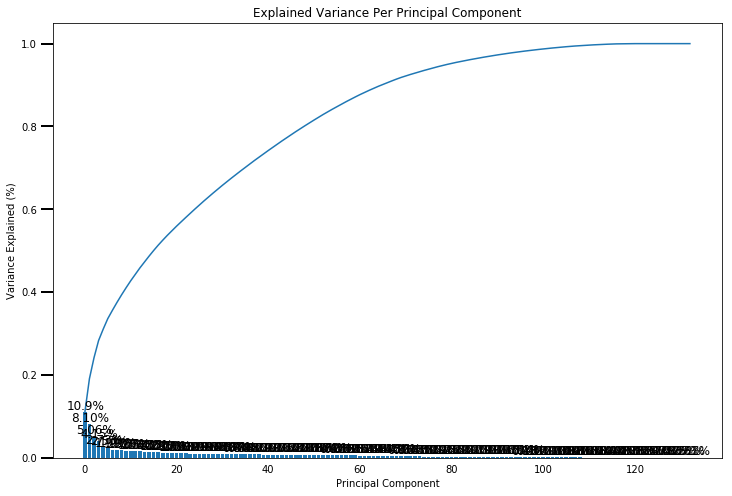

In [21]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca)

In [22]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components=40)
azdias_pca = pca.fit_transform(azdias_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

**Q. Regarding dimensionality reduction, how many principal components / transformed features are you retaining for the next step of the analysis?**

From the scree plot, we can see that we can capture roughly 70% of the variance with only 40 features. This is less than 1/3rd of the total features we have. Since this is a good tradeoff, I will be going forward with this number.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [24]:
def get_component_weights(pca, component_no):
    
    pca.components_[component_no]

    s1 = pd.Series(pca.components_[component_no])
    s1.index = azdias_scaled.columns
    
    print(f"Top positive weights for PCA{component_no}")    
    print (s1.sort_values(ascending=False)[0:5])
    print(f"Top negative weights for PCA{component_no}")
    print (s1.sort_values(ascending=True)[0:5])

In [27]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

get_component_weights(pca, 0)

Top positive weights for PCA0
LP_STATUS_GROB_1.0    0.197393
PLZ8_ANTG3            0.188544
HH_EINKOMMEN_SCORE    0.185716
PLZ8_ANTG4            0.181607
ORTSGR_KLS9           0.167577
dtype: float64
Top negative weights for PCA0
MOBI_REGIO          -0.207308
FINANZ_MINIMALIST   -0.192643
KBA05_ANTG1         -0.190261
PLZ8_ANTG1          -0.187752
KBA05_GBZ           -0.183462
dtype: float64


In [28]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

get_component_weights(pca, 1)

Top positive weights for PCA1
ALTERSKATEGORIE_GROB    0.236137
FINANZ_VORSORGER        0.223173
ZABEOTYP_3.0            0.205882
SEMIO_ERL               0.189706
SEMIO_LUST              0.165375
dtype: float64
Top negative weights for PCA1
FINANZ_SPARER           -0.227572
SEMIO_REL               -0.220527
FINANZ_UNAUFFAELLIGER   -0.217974
SEMIO_TRADV             -0.212515
SEMIO_PFLICHT           -0.207808
dtype: float64


In [29]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

get_component_weights(pca, 2)

Top positive weights for PCA2
SEMIO_VERT       0.316302
SEMIO_SOZ        0.252427
SEMIO_FAM        0.250946
SEMIO_KULT       0.240102
FINANZTYP_5.0    0.144858
dtype: float64
Top negative weights for PCA2
ANREDE_KZ    -0.339731
SEMIO_KAEM   -0.307122
SEMIO_DOM    -0.275896
SEMIO_KRIT   -0.263513
SEMIO_ERL    -0.196417
dtype: float64


### Discussion 2.3: Interpret Principal Components

**Q. What are your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?**

In my analysis, I am looking only at the top 5 positive and negative weights among the eigen vectors of the PCA, since the heaviest features determine where the PCA is leaning towards.

According to the information from  http://www.ddsgeo.com/products/plz8.html, the term PLZ8 refers to an orginizational structure in Germany to group 500 households together. Full explanation is avaible at the website, and a summary is given below:
"For PLZ8 the approximately 8,200 PLZ5 regions in Germany were coded with an additional 3-digit number. All postcodes were subdivided into areas that on average show 500 households, while the PLZ5 regions on average contain 10,000 inhabitants with a spread of 0 to 50,000."

"Microcell" appears a lot in the data dictionary and it appears to be a sub division/area under a PLZ area.

PCA0

Top positive weights for PCA0:

LP_STATUS_GROB_1.0 (Social status - Low income earners)
PLZ8_ANTG3 (Number of 6-10 family houses in the PLZ8 region)
HH_EINKOMMEN_SCORE (Estimated household net income)
PLZ8_ANTG4 (Number of 10+ family houses in the PLZ8 region)
ORTSGR_KLS9 (Size of community)

Top negative weights for PCA0
MOBI_REGIO (Movement patterns)
FINANZ_MINIMALIST (Financial - Low financial interest)
KBA05_ANTG1 (Number of 1-2 family houses in the microcell)
PLZ8_ANTG1 (Number of 1-2 family houses in the PLZ8 region)
KBA05_GBZ (Number of buildings in the microcell)

The top weights from this PCA tells us about the socio economic status, financial awareness and nature of the domicile of this population. This data appears to correspond to young people, who are earn less and live in densely populated areas and moves often. They are also not that interested in finances.

PCA1

Top positive weights for PCA1:
ALTERSKATEGORIE_GROB (Estimated age)
FINANZ_VORSORGER (Financial - Be prepared)
ZABEOTYP_3.0 (Enengy consumption - Fair)
SEMIO_ERL (Personality - Event oriented)
SEMIO_LUST (Personality - Sensual minded))

Top negative weights for PCA1:
FINANZ_SPARER(Financial - Saver)
SEMIO_REL (Personality - Religious)
FINANZ_UNAUFFAELLIGER (Financial - Inconsipicous)
SEMIO_TRADV (Personality - Traditional minded)
SEMIO_PFLICHT (Personality - Dutiful)

This principle component gives us an idea about financial habits, personal beliefs and nature of the persons. The PCA also includes the ALTERSKATEGORIE_GROB (estimated age), which makes conclude that the PCA is referring to conservative, elderly population, who are cautious spenders and also savers.

PCA2

Top positive weights for PCA2:
SEMIO_VERT (Presonality - Dreamful)
SEMIO_SOZ (Personality - Socially minded)
SEMIO_FAM (Personality - Family minded)
SEMIO_KULT (Personality - Cultural minded)
FINANZTYP_5.0 (Investor)

Top negative weights for PCA2:
ANREDE_KZ (Gender)
SEMIO_KAEM (Personality - Combative attitue)
SEMIO_DOM (Personality - Dominant minded)
SEMIO_KRIT (Personality - Critical minded)
SEMIO_ERL (Personality - Event Oriented)

This group refers to individuals who are family and society oriented, who are also rational decisionmakes. This also includes financially savvy investors who could be men.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [30]:
from sklearn.cluster import KMeans
import time

In [31]:
# Over a number of different cluster counts...

# run k-means clustering on the data and...

# compute the average within-cluster distances.

def plot_custer_scores(data):

    centers = []
    scores = []

    for i in range(5,30,2):
        print(f"Running k-means with {i} clusters. ", end =" ")
        time_start = time.time()
        clusterer = KMeans(n_clusters=i, random_state=0)
        clusterer.fit(data)    
        score = np.abs(clusterer.score(data))
        centers.append(i)    
        scores.append(score)
        print(f"Score: {score}", end=" ")
        print(f"[Time: {(time.time() - time_start)/60:.2f} mins]")
        
    return centers, scores

Running k-means with 5 clusters.  Score: 60111438.47389152 [Time: 1.16 mins]
Running k-means with 7 clusters.  Score: 57442944.48279148 [Time: 2.29 mins]
Running k-means with 9 clusters.  Score: 55599981.817898646 [Time: 2.75 mins]
Running k-means with 11 clusters.  Score: 54266477.063425496 [Time: 5.58 mins]
Running k-means with 13 clusters.  Score: 53075353.25235515 [Time: 4.95 mins]
Running k-means with 15 clusters.  Score: 52159435.50776168 [Time: 7.95 mins]
Running k-means with 17 clusters.  Score: 51351795.909181215 [Time: 7.63 mins]
Running k-means with 19 clusters.  Score: 50552036.561525345 [Time: 11.44 mins]
Running k-means with 21 clusters.  Score: 50033869.75263504 [Time: 9.51 mins]
Running k-means with 23 clusters.  Score: 49222113.734167986 [Time: 11.45 mins]
Running k-means with 25 clusters.  Score: 48579646.90250387 [Time: 10.62 mins]
Running k-means with 27 clusters.  Score: 48034296.80513245 [Time: 11.25 mins]
Running k-means with 29 clusters.  Score: 47653908.3452522

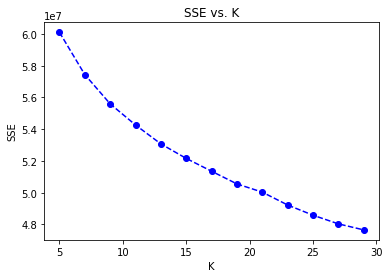

In [44]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

centers, scores = plot_custer_scores(azdias_pca)

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [32]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

clusterer = KMeans(n_clusters=15, random_state=0)
azdias_preds = clusterer.fit_predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

**Q. Into how many clusters have you decided to segment the population?)**

From the elbow plot, we can see that the best results happen when the number of clusters is 15. The average difference from each point to its assigned cluster's center doesn't seem to be imporing in proportion to the number of clusters after this point.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [33]:
# Load in the customer demographics data.
customers = pd.read_csv(filepath_or_buffer='Udacity_CUSTOMERS_Subset.csv', delimiter=";")
customers.shape

(191652, 85)

In [34]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Segregate the data based on how many NaN values are present
customers1 = customers[customers.isnull().sum(axis=1) <= 20]
print(f"Rows where NaNs <= 20: {customers1.shape}")
customers2 = customers[customers.isnull().sum(axis=1) > 20]
print(f"Rows where NaNs > 20: {customers2.shape}")

# We will proceed with only rows that has less NaN values
customers = customers1.copy()
customers = clean_data(customers)
customers.shape

Rows where NaNs <= 20: (141619, 85)
Rows where NaNs > 20: (50033, 85)


(141619, 133)

In [44]:
# Save the updated azdias for later use
customers.to_csv('customers_clean.csv')
customers.shape

(141619, 139)

In [35]:
# Use the imputer to replace NaN values in colums with the median value
customers[['GEBAEUDETYP_RASTER','ALTERSKATEGORIE_GROB','HEALTH_TYP','LP_LEBENSPHASE_FEIN','RETOURTYP_BK_S','VERS_TYP','W_KEIT_KIND_HH',
           'ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','KONSUMNAEHE','KBA05_ANTG1','KBA05_ANTG2','KBA05_ANTG3','KBA05_ANTG4',
           'KBA05_GBZ','BALLRAUM','EWDICHTE','INNENSTADT','KKK','MOBI_REGIO','ONLINE_AFFINITAET','REGIOTYP','KBA13_ANZAHL_PKW',
           'PLZ8_ANTG1','PLZ8_ANTG2','PLZ8_ANTG3','PLZ8_ANTG4','PLZ8_HHZ','PLZ8_GBZ','ARBEIT','ORTSGR_KLS9','RELAT_AB']] = imp_nan.transform(customers[['GEBAEUDETYP_RASTER','ALTERSKATEGORIE_GROB','HEALTH_TYP','LP_LEBENSPHASE_FEIN','RETOURTYP_BK_S','VERS_TYP','W_KEIT_KIND_HH','ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','KONSUMNAEHE','KBA05_ANTG1','KBA05_ANTG2','KBA05_ANTG3','KBA05_ANTG4','KBA05_GBZ','BALLRAUM','EWDICHTE','INNENSTADT','KKK','MOBI_REGIO','ONLINE_AFFINITAET','REGIOTYP','KBA13_ANZAHL_PKW','PLZ8_ANTG1','PLZ8_ANTG2','PLZ8_ANTG3','PLZ8_ANTG4','PLZ8_HHZ','PLZ8_GBZ','ARBEIT','ORTSGR_KLS9','RELAT_AB']])

In [36]:
# Check for any NaN values
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(customers.isnull().sum())

ALTERSKATEGORIE_GROB        0
ANREDE_KZ                   0
FINANZ_MINIMALIST           0
FINANZ_SPARER               0
FINANZ_VORSORGER            0
FINANZ_ANLEGER              0
FINANZ_UNAUFFAELLIGER       0
FINANZ_HAUSBAUER            0
GREEN_AVANTGARDE            0
HEALTH_TYP                  0
LP_LEBENSPHASE_FEIN         0
RETOURTYP_BK_S              0
SEMIO_SOZ                   0
SEMIO_FAM                   0
SEMIO_REL                   0
SEMIO_MAT                   0
SEMIO_VERT                  0
SEMIO_LUST                  0
SEMIO_ERL                   0
SEMIO_KULT                  0
SEMIO_RAT                   0
SEMIO_KRIT                  0
SEMIO_DOM                   0
SEMIO_KAEM                  0
SEMIO_PFLICHT               0
SEMIO_TRADV                 0
SOHO_KZ                     0
VERS_TYP                    0
ANZ_PERSONEN                0
ANZ_TITEL                   0
HH_EINKOMMEN_SCORE          0
W_KEIT_KIND_HH              0
WOHNDAUER_2008              0
ANZ_HAUSHA

In [37]:
# Apply feature scaling 

scaled_output = scaler.transform(customers)

# Covert the ndarray back to a dataframe
customers_scaled = pd.DataFrame(scaled_output)
customers_scaled.columns = customers.columns

customers_scaled.head()

C:\Users\urdee\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,HOUSEHOLD_LIFESTAGE_3.0,HOUSEHOLD_LIFESTAGE_4.0,HOUSEHOLD_LIFESTAGE_5.0,RURAL_NEIGHBORHOOD_0.0,RURAL_NEIGHBORHOOD_1.0,NEIGHBORHOOD_QUALITY_1.0,NEIGHBORHOOD_QUALITY_2.0,NEIGHBORHOOD_QUALITY_3.0,NEIGHBORHOOD_QUALITY_4.0,NEIGHBORHOOD_QUALITY_5.0
0,1.184051,-1.043765,1.409069,-1.155304,1.137960,-1.249881,-0.469752,-0.792034,1.884775,-1.610682,...,2.381119,-0.641840,-0.414645,-1.767232,1.808870,-0.241344,-0.379371,-0.674980,-0.45326,-0.320556
1,1.184051,0.958071,1.409069,-1.155304,1.137960,-1.249881,0.959677,0.628533,1.884775,-0.257263,...,-0.419971,1.558021,-0.414645,0.565857,-0.552831,-0.241344,2.635942,-0.674980,-0.45326,-0.320556
2,1.184051,-1.043765,1.409069,-1.155304,1.137960,-0.570799,-1.184467,-0.792034,-0.530567,-0.257263,...,-0.419971,1.558021,-0.414645,-1.767232,1.808870,-0.241344,-0.379371,-0.674980,-0.45326,-0.320556
3,0.200589,-1.043765,-0.042770,-1.155304,0.411731,0.787366,1.674391,-0.792034,-0.530567,1.096155,...,-0.419971,-0.641840,-0.414645,0.565857,-0.552831,-0.241344,-0.379371,1.481526,-0.45326,-0.320556
4,0.200589,-1.043765,1.409069,-1.155304,1.137960,-1.249881,-0.469752,-0.081750,1.884775,1.096155,...,-0.419971,1.558021,-0.414645,0.565857,-0.552831,4.143468,-0.379371,-0.674980,-0.45326,-0.320556


In [38]:
# Apply PCA to the data.

customers_pca = pca.transform(customers_scaled)

In [39]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

customers_preds = clusterer.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [40]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Converting ndarray to a data frame
azdias_preds_df = pd.DataFrame(azdias_preds, columns=['CLUSTER'])
# Adding the ignored rows from azdias data set as cluster no 15.
azdias_nans = pd.DataFrame((np.ones(azdias2.shape[0])*15).astype(int), index=azdias2.index, columns=['CLUSTER'])
azdias_total = pd.concat([azdias_preds_df, azdias_nans])
azdias_total['SOURCE']='azdias'

customers_preds_df = pd.DataFrame(customers_preds, columns=['CLUSTER'])
# Adding the ignored rows from customers data set as cluster no 15.
customers_nans = pd.DataFrame((np.ones(customers2.shape[0])*15).astype(int), index=customers2.index, columns=['CLUSTER'])
customers_total = pd.concat([customers_preds_df, customers_nans])
customers_total['SOURCE']='customers'

#azdias_total.groupby(['CLUSTER'])['CLUSTER'].count()
#azdias_total

#customers_total.groupby(['CLUSTER'])['CLUSTER'].count()
#customers_total

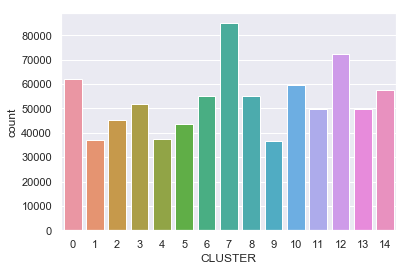

In [41]:
sns.set(style="darkgrid")
ax = sns.countplot(x="CLUSTER", data=azdias_preds_df)

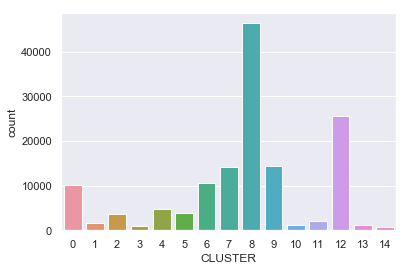

In [42]:
sns.set(style="darkgrid")
ax = sns.countplot(x="CLUSTER", data=customers_preds_df)

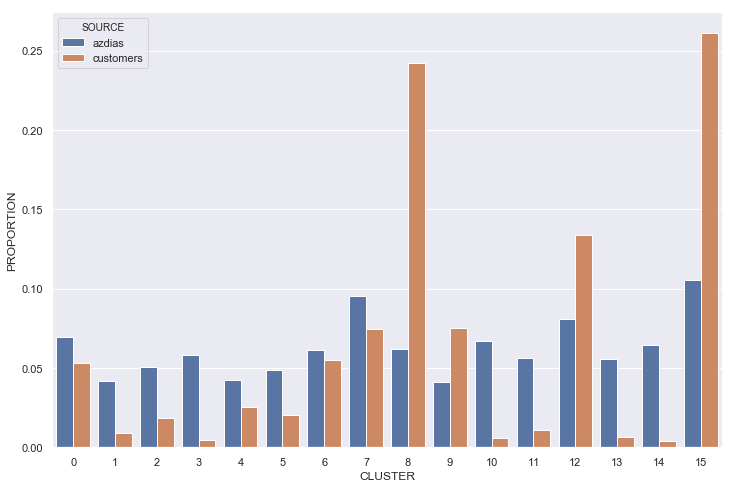

In [43]:
# Sum up the items in the cluster and change to proportional values

azdias_prop = azdias_total.groupby('CLUSTER')['CLUSTER'].count()
azdias_prop = azdias_prop/azdias_prop.sum()
azdias_prop_df = pd.DataFrame(azdias_prop)
azdias_prop_df.columns = ['PROPORTION']
azdias_prop_df = azdias_prop_df.reset_index()
azdias_prop_df['SOURCE']='azdias'
#azdias_prop_df

customers_prop = customers_total.groupby('CLUSTER')['CLUSTER'].count()
customers_prop = customers_prop/customers_prop.sum()
customers_prop_df = pd.DataFrame(customers_prop)
customers_prop_df.columns = ['PROPORTION']
customers_prop_df = customers_prop_df.reset_index()
customers_prop_df['SOURCE']='customers'
#customers_prop_df

total_data = pd.concat([azdias_prop_df, customers_prop_df], ignore_index=True)
#total_data

# Plot the results
fig, ax = plt.subplots(figsize=(12,8))

sns.set(style="darkgrid")
x = sns.barplot(ax=ax, x="CLUSTER", y="PROPORTION", hue="SOURCE", data=total_data)

From the above plots, we can observe that clusters 8, 9, 12 and 15 are over represented among customer data by a large margin. Similarly, among the remaining clusters, clusters 3, 10, 11, 13, and 14 are under represented by a significant margin.

In [44]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

cluster_8_transformed_out  = scaler.inverse_transform(pca.inverse_transform(clusterer.cluster_centers_[8]))
cluster_8 = pd.Series(data = cluster_8_transformed_out , index = customers.columns)
print(cluster_8.sort_values(ascending=False))

MIN_GEBAEUDEJAHR            1992.710520
KBA13_ANZAHL_PKW             680.179768
LP_LEBENSPHASE_FEIN           23.750137
WOHNDAUER_2008                 8.601886
SEMIO_VERT                     6.279788
ORTSGR_KLS9                    5.516804
SEMIO_SOZ                      5.298070
SEMIO_LUST                     5.262854
SEMIO_KULT                     4.943138
SEMIO_FAM                      4.906798
FINANZ_MINIMALIST              4.760694
INNENSTADT                     4.485218
FINANZ_VORSORGER               4.366771
W_KEIT_KIND_HH                 4.236579
MOBI_REGIO                     4.097505
EWDICHTE                       4.091742
KBA05_GBZ                      4.066394
SEMIO_ERL                      4.007622
GEBAEUDETYP_RASTER             3.957625
RETOURTYP_BK_S                 3.917872
SEMIO_MAT                      3.892611
BALLRAUM                       3.865309
PLZ8_GBZ                       3.851685
SEMIO_REL                      3.832883
PLZ8_HHZ                       3.673378


In [45]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

cluster_3_transformed_out  = scaler.inverse_transform(pca.inverse_transform(clusterer.cluster_centers_[3]))
cluster_3 = pd.Series(data = cluster_3_transformed_out , index = customers.columns)
print(cluster_3.sort_values(ascending=False))

MIN_GEBAEUDEJAHR            1992.604421
KBA13_ANZAHL_PKW             536.717798
ANZ_HAUSHALTE_AKTIV           14.911929
LP_LEBENSPHASE_FEIN            9.161277
WOHNDAUER_2008                 6.837819
ORTSGR_KLS9                    6.691971
SEMIO_KULT                     6.649577
SEMIO_FAM                      6.573365
SEMIO_SOZ                      6.401345
SEMIO_REL                      6.082852
SEMIO_VERT                     5.914255
HH_EINKOMMEN_SCORE             5.508079
SEMIO_PFLICHT                  5.406631
REGIOTYP                       4.994486
EWDICHTE                       4.921076
SEMIO_MAT                      4.878106
SEMIO_TRADV                    4.699887
FINANZ_SPARER                  4.639628
W_KEIT_KIND_HH                 4.608575
FINANZ_UNAUFFAELLIGER          4.068773
SEMIO_RAT                      3.968183
FINANZ_HAUSBAUER               3.824842
FINANZ_ANLEGER                 3.774597
PLZ8_HHZ                       3.761529
ARBEIT                         3.622595


### Discussion 3.3: Compare Customer Data to Demographics Data

**Q. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?**

From the analysis conducted above, we can conclude that the CLUSTER 8 is over represented, and therefore more popular with the company. CLUSTER 3 is under represented in the company. We will look at these sengments in detail below.

CLUSTER 8 (Over represented)

This cluster consists of people how are 46 - 60 years old, highly religious, single parent, high-income earners who are city dwellers. They are less likely to move frequently, and they have been staying at the present residence for 7-10 years. They belong to upper middle class, with average possibility of children living with them. They stay in areas with mixed commercial and residential buildings with 20,001 to  50,000 inhabitants in community. They have low financial interest.

CLUSTER 3 (Under represented)

This cluster consists of single independent persons, belonging to middle class with lower income who stay within 3 -  5 km to the city center. They live in larger urban communites with 50,001 to 100,000 inhabitants, with average share of unemployment. They have been staying at the present residence for 5-6 years, so they tend to move a lot more often. They have average inclination towards saving money, and being a home owner and investing.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.